In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

data_root = 'plates/'
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device


device(type='cuda', index=0)

In [6]:
# with zipfile.ZipFile('input/plates.zip', 'r') as zip_obj:    
#    zip_obj.extractall('/kaggle/working/')

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


100%|██████████| 100/100 [00:00<00:00, 1111.14it/s]


In [28]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
    transforms.RandomChoice([transforms.CenterCrop(180),
                                transforms.CenterCrop(160),
                                transforms.CenterCrop(140),
                                transforms.CenterCrop(120),
                                transforms.Compose([transforms.CenterCrop(280),
                                                    transforms.Grayscale(3),
                                                    ]),
                                transforms.Compose([transforms.CenterCrop(200),
                                                    transforms.Grayscale(3),
                                                    ]),
                                ]),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        #scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                if epoch_loss < best_valid_loss:
                    best_valid_loss = epoch_loss
                    model_scripted = torch.jit.script(model)
                    model_scripted.save('model_scripted.pt') 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    #return model

c:\Study\Computer vision\env\lib\site-packages\torchvision\transforms\transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [29]:
class MyResNet50(torch.nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.net = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x
    
# model = MyResNet50()

In [30]:
model = MyResNet50().to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_model(model, loss, optimizer, scheduler, num_epochs=30)


# plt.plot(train_loss_list, c='r')
# plt.plot(train_acc_list, c='b')


Epoch 0/29:


100%|██████████| 20/20 [00:04<00:00,  4.62it/s]

train Loss: 0.6625 Acc: 0.5813



100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


val Loss: 0.6271 Acc: 0.5750
Epoch 1/29:


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]

train Loss: 0.4213 Acc: 0.8375



100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


val Loss: 0.6167 Acc: 0.7500
Epoch 2/29:


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]

train Loss: 0.3869 Acc: 0.8125



100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


val Loss: 0.4541 Acc: 0.7750
Epoch 3/29:


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

train Loss: 0.3129 Acc: 0.8938



100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


val Loss: 0.4209 Acc: 0.8250
Epoch 4/29:


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

train Loss: 0.1620 Acc: 0.9438



100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


val Loss: 0.3073 Acc: 0.8750
Epoch 5/29:


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

train Loss: 0.1925 Acc: 0.9313



100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


val Loss: 0.3016 Acc: 0.8750
Epoch 6/29:


100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

train Loss: 0.1011 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00,  5.76it/s]

val Loss: 0.3193 Acc: 0.8750
Epoch 7/29:



100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

train Loss: 0.1201 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


val Loss: 0.2508 Acc: 0.9250
Epoch 8/29:


100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

train Loss: 0.1302 Acc: 0.9500



100%|██████████| 5/5 [00:00<00:00,  5.19it/s]

val Loss: 0.2870 Acc: 0.8750
Epoch 9/29:



100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

train Loss: 0.1227 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  8.18it/s]

val Loss: 0.3295 Acc: 0.8750
Epoch 10/29:



100%|██████████| 20/20 [00:02<00:00,  9.69it/s]

train Loss: 0.0962 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00, 14.95it/s]

val Loss: 0.2957 Acc: 0.8750
Epoch 11/29:



100%|██████████| 20/20 [00:01<00:00, 10.73it/s]

train Loss: 0.1783 Acc: 0.9187



100%|██████████| 5/5 [00:00<00:00, 14.84it/s]


val Loss: 0.2414 Acc: 0.9250
Epoch 12/29:


100%|██████████| 20/20 [00:01<00:00, 10.96it/s]

train Loss: 0.1208 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00, 13.30it/s]

val Loss: 0.2742 Acc: 0.9250
Epoch 13/29:



100%|██████████| 20/20 [00:01<00:00, 10.81it/s]

train Loss: 0.1090 Acc: 0.9688



100%|██████████| 5/5 [00:00<00:00, 15.72it/s]

val Loss: 0.3106 Acc: 0.8750
Epoch 14/29:



100%|██████████| 20/20 [00:01<00:00, 11.18it/s]

train Loss: 0.1090 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

val Loss: 0.3207 Acc: 0.8750
Epoch 15/29:



100%|██████████| 20/20 [00:01<00:00, 11.46it/s]

train Loss: 0.1210 Acc: 0.9500



100%|██████████| 5/5 [00:00<00:00, 16.03it/s]

val Loss: 0.2871 Acc: 0.9250
Epoch 16/29:



100%|██████████| 20/20 [00:01<00:00, 11.15it/s]

train Loss: 0.1051 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

val Loss: 0.2840 Acc: 0.9250
Epoch 17/29:



100%|██████████| 20/20 [00:01<00:00, 11.11it/s]

train Loss: 0.0961 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00, 16.03it/s]

val Loss: 0.2811 Acc: 0.9250
Epoch 18/29:



100%|██████████| 20/20 [00:01<00:00, 10.88it/s]

train Loss: 0.0959 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

val Loss: 0.3024 Acc: 0.8750
Epoch 19/29:



100%|██████████| 20/20 [00:01<00:00, 11.03it/s]

train Loss: 0.0994 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00, 16.03it/s]

val Loss: 0.2782 Acc: 0.8750
Epoch 20/29:



100%|██████████| 20/20 [00:01<00:00, 10.82it/s]

train Loss: 0.1453 Acc: 0.9438



100%|██████████| 5/5 [00:00<00:00, 15.92it/s]

val Loss: 0.2534 Acc: 0.9250
Epoch 21/29:



100%|██████████| 20/20 [00:01<00:00, 10.93it/s]

train Loss: 0.1059 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00, 16.08it/s]

val Loss: 0.3051 Acc: 0.8750
Epoch 22/29:



100%|██████████| 20/20 [00:01<00:00, 11.31it/s]

train Loss: 0.1104 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00, 15.92it/s]

val Loss: 0.2610 Acc: 0.9250
Epoch 23/29:



100%|██████████| 20/20 [00:01<00:00, 11.18it/s]

train Loss: 0.0964 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00, 15.92it/s]

val Loss: 0.2886 Acc: 0.9250
Epoch 24/29:



100%|██████████| 20/20 [00:01<00:00, 11.05it/s]

train Loss: 0.1130 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00, 15.87it/s]

val Loss: 0.2912 Acc: 0.8750
Epoch 25/29:



100%|██████████| 20/20 [00:01<00:00, 11.04it/s]

train Loss: 0.0855 Acc: 0.9688



100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


val Loss: 0.2341 Acc: 0.9250
Epoch 26/29:


100%|██████████| 20/20 [00:01<00:00, 10.67it/s]

train Loss: 0.1046 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00, 16.03it/s]

val Loss: 0.2868 Acc: 0.8750
Epoch 27/29:



100%|██████████| 20/20 [00:01<00:00, 11.17it/s]

train Loss: 0.1222 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00, 15.97it/s]

val Loss: 0.2793 Acc: 0.8750
Epoch 28/29:



100%|██████████| 20/20 [00:01<00:00, 11.12it/s]

train Loss: 0.1292 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00, 14.37it/s]

val Loss: 0.2820 Acc: 0.8750
Epoch 29/29:



100%|██████████| 20/20 [00:01<00:00, 11.33it/s]

train Loss: 0.0809 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00, 16.13it/s]


val Loss: 0.2637 Acc: 0.9250


In [24]:
image_transforms = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

with Image.open('../Lab4/img/1.jpg') as img:
    img = image_transforms(img)
# with Image.open('img/1.jpg') as img:
#     img = image_transforms(img)

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

# img_1 = transforms.functional.crop(img, 12, 441, 237, 623) 

img_1 =  img[:, 12:237, 441:623]
print(img_1)

show_input(img_1)

NameError: name 'Image' is not defined

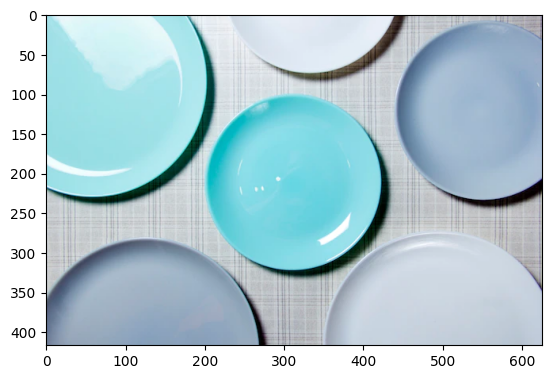

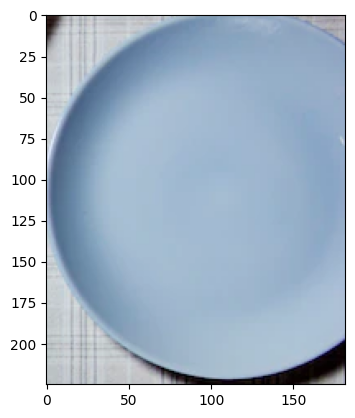

In [26]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import random

image_transforms = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

with Image.open('../Lab4/img/1.jpg') as img:
    img = image_transforms(img)
# with Image.open('img/1.jpg') as img:
#     img = image_transforms(img)

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

# img_1 = transforms.functional.crop(img, 12, 441, 237, 623) 

img_1 =  img[:, 12:237, 441:623]
# print(img_1)

show_input(img)
show_input(img_1)